# Extract_AGDC_for_study_sites

This code extracts all available measurement data for each of a list of case study sites, then saves the time averaged output to a netcdf file for later use. This code was designed to minimise the amount of time required to perform analyses with datacube data over known areas. By creating the netcdf files of each measurement, these can be called in by another program and quickly analysed to look for patterns. 

Note that the netcdf files should eventually be deleted once the further analyses have been conducted to avoid duplication of data, and to save memory on /g/data.

Created by Claire Krause
January 2017
Datacube version 1.1.13

### Dependancies in this code:
 - csv file with the lat/lon coordinates of the case study bounding box/es

### Accompanying code

Accompanying code has been written for raijin to allow for multiple study sites to be processed at once. The code runs on a single CPU, which run on raijin in a non-interactive way. The outputs from this code are written into /g/data. These codes can be found at https://github.com/CEKrause/Palaeovalleys_AGDC
-  Extract_AGDC_for_study_sites_raijin.py

In [1]:
# Import the libraries we need in the code and tell matplotlib to display the plots here
%matplotlib inline
import fiona
import shapely.geometry
import rasterio
import rasterio.features
import datacube
datacube.set_options(reproject_threads=1)
import numpy as np
from datacube.storage import masking
import matplotlib.pyplot as plt
import xarray as xr
import scipy.stats
import pandas
import os 

In [2]:
# Set up some functions to use later in the code
def warp_geometry(geom, src_crs, dst_crs):
    """
    warp geometry from src_crs to dst_crs
    """
    return shapely.geometry.shape(rasterio.warp.transform_geom(src_crs, dst_crs, shapely.geometry.mapping(geom)))

def geometry_mask(geom, geobox, all_touched=False, invert=False):
    """
    rasterize geometry into a binary mask where pixels that overlap geometry are False
    """
    return rasterio.features.geometry_mask([geom],
                                           out_shape=geobox.shape,
                                           transform=geobox.affine,
                                           all_touched=all_touched,
                                           invert=invert)

def pq_fuser(dest, src):
    valid_bit = 8
    valid_val = (1 << valid_bit)

    no_data_dest_mask = ~(dest & valid_val).astype(bool)
    np.copyto(dest, src, where=no_data_dest_mask)

    both_data_mask = (valid_val & dest & src).astype(bool)
    np.copyto(dest, src & dest, where=both_data_mask)

def return_good_pixels(nbar, pq):
    """
    This function uses pixel quality information to mask out and remove pixel quality artifacts from extracted data.
    """
    mask_components = {'cloud_acca':'no_cloud',
    'cloud_shadow_acca' :'no_cloud_shadow',
    'cloud_shadow_fmask' : 'no_cloud_shadow',
    'cloud_fmask' :'no_cloud',
    'blue_saturated' : False,
    'green_saturated' : False,
    'red_saturated' : False,
    'nir_saturated' : False,
    'swir1_saturated' : False,
    'swir2_saturated' : False,
    'contiguous':True}
    pqmask = masking.make_mask(pq.pixelquality,  **mask_components)
    return nbar.where(pqmask)

## Import our list of case study sites and accompanying bounding boxes

In [3]:
# Set up the case study bounding box (to make the file smaller and avoid memory errors)
# Read in a csv file with all case study bounding boxes
names = pandas.read_csv('/g/data/p25/cek156/case_study_sites_small.csv', delimiter = ',')
print(names)

           Name     minlat     maxlat      minlon      maxlon
0   Blackwood2A -34.100000 -33.400000  116.400000  117.400000
1   Blackwood2B -34.100000 -33.400000  117.400000  118.400000
2   Blackwood2C -33.400000 -32.700000  116.400000  117.400000
3   Blackwood2D -33.400000 -32.700000  117.400000  118.400000
4      GarfordA -29.900000 -29.230000  133.150000  133.925000
5      GarfordB -29.900000 -29.230000  133.925000  134.700000
6     Mandora1A -21.100000 -20.356667  120.900000  121.916667
7     Mandora1B -21.100000 -20.356667  121.916667  122.933333
8     Mandora1C -21.100000 -20.356667  122.933333  123.950000
9     Mandora1D -21.100000 -20.356667  123.950000  124.966667
10    Mandora1E -21.100000 -20.356667  124.966667  125.983333
11    Mandora1F -21.100000 -20.356667  125.983333  127.000000
12    Mandora1G -20.356667 -19.613333  120.900000  121.916667
13    Mandora1H -20.356667 -19.613333  121.916667  122.933333
14    Mandora1I -20.356667 -19.613333  122.933333  123.950000
15    Ma

In [4]:
# Choose your site for this example
# Here we will select the Ord
num = 40
Studysite = names.ix[num]
print(Studysite)

Name         Ord
minlat    -15.93
maxlat    -15.05
minlon     128.3
maxlon    129.29
Name: 40, dtype: object


Here is where you need to define the parameters of your analysis. There is an accompanying code that loops through these steps with all of the wet/dry times and case study sites. Here we are just demonstrating the functionality of the code, so we will choose just one wet year for our analysis. 

In [5]:
#### DEFINE SPATIOTEMPORAL RANGE AND BANDS OF INTEREST

#Define sensors of interest
sensors = ['ls8', 'ls7', 'ls5'] 

query = {'lat': (names.maxlat[num], names.minlat[num]), 
         'lon': (names.minlon[num], names.maxlon[num]),
         'resolution': (-250, 250)}

# NB. The resolution has been set to 1/10th of the native landsat resolution of 25 m x 25 m. This is to save memory and 
# time on extraction.

query

{'lat': (-15.050000000000001, -15.93),
 'lon': (128.30000000000001, 129.28999999999999),
 'resolution': (-250, 250)}

## Grab some data from the datacube using the query we built above. 
We are then going to clean up the data to remove poor quality pixels, and create a mean so we only have one time step to play with.

For this example, we will just grab data from the 'blue' band, but this will be looped in a subsequent notebook.

In [6]:
# Pull in some data from the datacube to apply our mask to
dc = datacube.Datacube(app='poly-drill-recipe')

#Define wavelengths/bands of interest, remove this kwarg to retrieve all bands
bands_of_interest = ['blue',
                     'green',
                     'red', 
                     'nir',
                     'swir1', 
                     'swir2',
                     ]

# Grab data from all three sensors (ls5, ls7 and ls8). We will loop through the three sensors, then calculate an average.
for idx, sensor in enumerate(sensors):
    #Retrieve the data and pixel quality (PQ) data for sensor n
    sens = 1
    nbar = dc.load(product = sensor +'_nbar_albers', group_by='solar_day', measurements = [bands_of_interest[0]],  **query)
    if nbar :    
        pq = dc.load(product = sensor +'_pq_albers', group_by='solar_day', fuse_func=pq_fuser, **query)
        crs = nbar.crs.wkt
        affine = nbar.affine
        geobox = nbar.geobox
        # Filter the data to remove bad pixels
        nbar = return_good_pixels(nbar, pq)
        print('Finished grabbing data for ' + sensor)
        if sens == 1:
            allsens = nbar
            sens = sens + 1
        elif sens == 2:
            allsens = xr.concat([allsens, nbar], dim = 'new_dim')
            sens = sens + 1
        else:
            nbar = xr.concat([nbar], dim = 'new_dim')
            allsens = xr.concat([allsens, nbar], dim = 'new_dim')
            sens = sens + 1                 
    if sens >= 3:
        datamean = allsens.mean(dim = 'new_dim') 
        datamean = datamean.mean(dim = 'time')
    else:
        datamean = allsens.mean(dim = 'time')

print(datamean)

Finished grabbing data for ls8
Finished grabbing data for ls7
Finished grabbing data for ls5
<xarray.Dataset>
Dimensions:  (x: 438, y: 398)
Coordinates:
  * y        (y) float64 -1.6e+06 -1.6e+06 -1.601e+06 -1.601e+06 -1.601e+06 ...
  * x        (x) float64 -4.011e+05 -4.009e+05 -4.006e+05 -4.004e+05 ...
Data variables:
    blue     (y, x) float64 545.7 790.0 756.7 572.8 526.0 637.6 592.8 565.8 ...


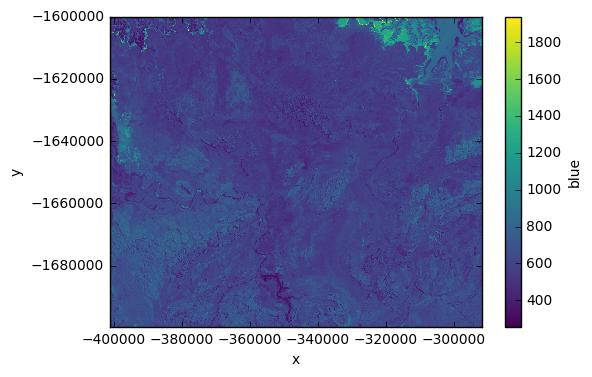

In [7]:
fig = datamean.blue.plot()

In [8]:
## Save the time-mean, all sensor mean data into a netcdf file for later use.
OUTPUT_dir = '/g/data/p25/cek156/' + names.Name[num]
OUTPUT_file = '/g/data/p25/cek156/' + names.Name[num] + '/' + names.Name[num] + '_' + bands_of_interest[0] + '_time_mean.nc'

# Check whether the Study site directory has been created, and if not, create it.
dir_check = os.path.isdir(OUTPUT_dir)
if dir_check == False:
    os.makedirs(OUTPUT_dir)

# Save the outputs so that we don't need to keep running this script
datamean.attrs['affine'] = affine
datamean.attrs['crs'] = crs
#ds.attrs['geobox'] = geobox
datamean.to_netcdf(path = OUTPUT_file, mode = 'w')
print('Saved ' + bands_of_interest[0] + ' averages for ' + names.Name[num])

Saved blue averages for Ord
